In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# from Index_Calculations import facility_index_gen
import os
import glob
import numpy as np
from statsmodels.tsa.tsatools import detrend
from os.path import join
import itertools

# Import NERC labels

In [ ]:
path = os.path.join('Data storage', 'Plant NERC regions.csv')
NERC_labels = pd.read_csv(path)
NERC_labels.columns = ['plant id', 'region', 'year']

## Calculate index values for each NERC region
This just uses facility data. Which is generally fine for 2015 and earlier, but it does omit DPV.

In [3]:
facility_path = os.path.join('Data storage', 'Facility gen fuels and CO2 2017-05-25.zip')
epa_path = os.path.join('Data storage', 'Derived data',
                        'Monthly EPA emissions 2017-05-25.csv')
ef_path = os.path.join('Data storage', 'Final emission factors.csv')
out_folder = os.path.join('Data storage', 'final NERC data')

In [4]:
facility = pd.read_csv(facility_path)
epa = pd.read_csv(epa_path)

### Translate NERC region names
For now, just change ERCOT to TRE.

In [5]:
NERC_labels.loc[NERC_labels['region'] == 'ERCOT', 'region'] = 'TRE'

In [20]:
for nerc in ['USA', 'TRE', 'FRCC', 'NPCC', 'RFC', 'SPP',
             'SERC', 'WECC', 'ASCC', 'MRO', 'HICC']:
    # Only use data from 2015 and earlier (final EIA data)
    facility_index_gen(eia_facility=facility.loc[(facility['year'] <= 2015)], 
                         epa=epa,
                         emission_factor_path=ef_path,
                         facility_regions=NERC_labels,
                         export_folder=out_folder, export_path_ext=' '
                         + nerc, region=nerc)

## Read data and create figures

In [2]:
path = os.path.join('Data storage', 'final NERC data', 'Monthly index*')
mi_fns = glob.glob(path)
path = os.path.join('Data storage', 'final NERC data', 'Monthly gen*')
mg_fns = glob.glob(path)

In [3]:
def make_gen_index(data_folder, regions, time='Monthly'):
    """
    Read and combine the region-level generation and index files
    
    inputs:
        data_folder: (str or path) path to the region-level data files
        time: (str) "Monthly", "Quarterly", or "Annual"
        
    outputs:
        gen_index: (df) a dataframe with combined generation and index data
    """
    
    index_path = os.path.join(data_folder, '{} index*'.format(time))
    gen_path = os.path.join(data_folder, '{} gen*'.format(time))
    
    # Get filenames and list of region abbreviations
    index_fns = glob.glob(index_path)
    gen_fns = glob.glob(gen_path)
    
    # Not sure why, but DC shows up in index but not gen
#     index_regions = [f.split('.')[0][-4:] for f in index_fns]
#     gen_regions = [f.split('.')[0][-4:] for f in gen_fns]
    
    
    # Read and combine files into single dataframes
    def read_combine(paths, regions):
        df_list = []
        for f, region in zip(paths, regions):
            df = pd.read_csv(f)
            df['region'] = region
            df_list.append(df)
        
        full_df = pd.concat(df_list)
        full_df.reset_index(inplace=True, drop=True)
        full_df.rename(columns={'year': 'Year'},
                       inplace=True)
        
        if 'datetime' in full_df.columns:
            full_df['datetime'] = pd.to_datetime(full_df['datetime'])
        
        return full_df
    
    index_df = read_combine(index_fns, regions)
    gen_df = read_combine(gen_fns, regions)
    
#     return index_df, gen_df
    
    # Different timescales will pivot on different columns
    gen_pivot_col = {'Monthly': ['Year', 'datetime'],
                     'Quarterly': ['Year', 'year_quarter'],
                     'Annual': ['Year']}
    
    gen_pivot = pd.pivot_table(gen_df, index=['region'] + gen_pivot_col[time], 
                               values='generation (MWh)', columns='fuel category')
    gen_pivot.reset_index(inplace=True, drop=False)
#     gen_pivot['Year'] = gen_pivot['datetime'].dt.year
    gen_pivot.replace(np.nan, 0, inplace=True)
    
    # Merge gen and index dataframes
    merge_col = {'Monthly': ['datetime'],
                 'Quarterly': ['year_quarter'],
                 'Annual': ['Year']}
    
    gen_index = pd.merge(gen_pivot, index_df[merge_col[time] + ['region', 'index (g/kWh)']], 
                         on=merge_col[time] + ['region'])
    
    return gen_index

In [4]:
data_path = os.path.join('Data storage', 'final NERC data')
# gen_index = make_gen_index(data_path, time='Monthly')
regions = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
annual_gen_index = make_gen_index(data_path, regions, time='Annual')

In [5]:
df_list = []
for f in mi_fns:
    region = f.split()[-1][:-4]
    df = pd.read_csv(f)
    df['region'] = region
    df_list.append(df)
full_mi = pd.concat(df_list)
full_mi.reset_index(inplace=True, drop=True)
full_mi.rename(columns={'index (g/kWh)': 'monthly index (g/kWh)'}, inplace=True)
full_mi['datetime'] = pd.to_datetime(full_mi['datetime'])

In [6]:
df_list = []
for f in mg_fns:
    region = f.split()[-1][:-4]
    df = pd.read_csv(f)
    df['region'] = region
    df_list.append(df)
full_mg = pd.concat(df_list)
full_mg.reset_index(inplace=True, drop=True)
full_mg['datetime'] = pd.to_datetime(full_mg['datetime'])

monthly_gen = pd.pivot_table(full_mg, index=['region', 'datetime'], 
                             values='generation (MWh)', columns='fuel category')
monthly_gen.reset_index(inplace=True, drop=False)
monthly_gen['Year'] = monthly_gen['datetime'].dt.year
monthly_gen.replace(np.nan, 0, inplace=True)

In [7]:
gen_index = pd.merge(monthly_gen, full_mi[['datetime', 'region', 'monthly index (g/kWh)']], 
                     on=['datetime', 'region'])
gen_index.head()

,region,datetime,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,Year,monthly index (g/kWh)
0,ASCC,2002-01-01,51623.345,118944.230,278301.715,0.0,105692.359,1091.837,0.0,0.0,2002,524.179128
1,ASCC,2002-02-01,44698.280,111685.818,226043.409,0.0,93737.860,920.883,0.0,0.0,2002,531.953278
2,ASCC,2002-03-01,48946.119,114826.098,242509.602,0.0,95438.279,1001.716,0.0,0.0,2002,551.999629
3,ASCC,2002-04-01,43484.123,111308.793,234060.059,0.0,67238.126,951.725,0.0,0.0,2002,523.407268
4,ASCC,2002-05-01,48711.393,108503.867,220310.309,0.0,68730.377,1002.904,0.0,0.0,2002,533.840903


There seems to be a large number of facilities left out of data before 2002. Take out 2001 for now.

In [8]:
gen_index = gen_index.loc[gen_index['Year'] >= 2002]

In [9]:
# define the mean absolute deviation as a function
mad = lambda x: np.fabs(x - x.mean()).mean()

for region in gen_index['region'].unique():
    gen_index.loc[gen_index['region'] == region, 'Index variability'] = \
        gen_index.loc[gen_index['region']==region, 
                       'monthly index (g/kWh)'].rolling(window=12).std()
    
    gen_index.loc[gen_index['region'] == region, 
                   'Normalized Index variability'] = \
         gen_index.loc[gen_index['region']==region, 'Index variability'] / \
         gen_index.loc[gen_index['region']==region, 
                       'monthly index (g/kWh)'].rolling(window=12).mean()
            
    # Also calculate variability using median absolute deviation (mad)
    gen_index.loc[gen_index['region'] == region, 'Index variability (MAD)'] = \
        gen_index.loc[gen_index['region']==region, 
                       'monthly index (g/kWh)'].rolling(window=12).apply(mad)
    
    gen_index.loc[gen_index['region'] == region, 
                   'Normalized Index variability (MAD)'] = \
         gen_index.loc[gen_index['region']==region, 'Index variability (MAD)'] / \
         gen_index.loc[gen_index['region']==region, 
                       'monthly index (g/kWh)'].rolling(window=12).mean()
gen_index.tail()

,region,datetime,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,Year,monthly index (g/kWh),Index variability,Normalized Index variability,Index variability (MAD),Normalized Index variability (MAD)
1831,WECC,2015-08-01,1.846815e+07,1.145648e+07,2.675591e+07,5431555.0,619411.556,2044535.468,2221255.278,4250555.439,2015,436.192584,33.203612,0.081226,27.825260,0.068069
1832,WECC,2015-09-01,1.638549e+07,9.673322e+06,2.513661e+07,5197506.0,592984.906,1868163.912,1854932.073,3225165.969,2015,438.285713,32.058926,0.078610,27.026756,0.066271
1833,WECC,2015-10-01,1.577100e+07,9.027061e+06,2.319022e+07,4002852.0,567863.847,1960396.275,1588800.044,3220602.728,2015,446.763806,31.695605,0.077769,26.809058,0.065779
1834,WECC,2015-11-01,1.376561e+07,1.022417e+07,1.879237e+07,4511483.0,554630.018,1980105.768,1473635.631,3638695.910,2015,411.262181,31.370839,0.077152,26.017113,0.063985
1835,WECC,2015-12-01,1.631912e+07,1.189232e+07,1.945283e+07,5429153.0,621373.984,2055900.008,1261369.497,4415151.642,2015,413.457361,31.344967,0.077107,25.934392,0.063797


In [10]:
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind',
         'Solar', 'Other', 'Other Renewables']
gen_index['Total Generation (MWh)'] = gen_index.loc[:, fuels].sum(axis=1)

In [11]:
gen_index.head()

,region,datetime,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,Year,monthly index (g/kWh),Index variability,Normalized Index variability,Index variability (MAD),Normalized Index variability (MAD),Total Generation (MWh)
0,ASCC,2002-01-01,51623.345,118944.230,278301.715,0.0,105692.359,1091.837,0.0,0.0,2002,524.179128,NaN,NaN,NaN,NaN,555653.486
1,ASCC,2002-02-01,44698.280,111685.818,226043.409,0.0,93737.860,920.883,0.0,0.0,2002,531.953278,NaN,NaN,NaN,NaN,477086.250
2,ASCC,2002-03-01,48946.119,114826.098,242509.602,0.0,95438.279,1001.716,0.0,0.0,2002,551.999629,NaN,NaN,NaN,NaN,502721.814
3,ASCC,2002-04-01,43484.123,111308.793,234060.059,0.0,67238.126,951.725,0.0,0.0,2002,523.407268,NaN,NaN,NaN,NaN,457042.826
4,ASCC,2002-05-01,48711.393,108503.867,220310.309,0.0,68730.377,1002.904,0.0,0.0,2002,533.840903,NaN,NaN,NaN,NaN,447258.850


I'm going to skip this for now. Difficult to have a base year for all regions.

In [27]:
base_year = 2007

In [28]:
fuels = ['Coal', 'Natural Gas', 'Other Renewables', 'Nuclear', 'Other',
         'Solar', 'Wind', 'Hydro']
gen_index['Total gen'] = gen_index.loc[:, fuels].sum(axis=1)
for fuel in fuels:
    # New columns that are being added
    col_percent = 'percent ' + fuel
    col_change = 'change in ' + fuel

    # Calculate percent of generation from each fuel type
    gen_index[col_percent] = gen_index.loc[:, fuel] / gen_index.loc[:, 'Total gen']

    # Percent of fuel in region in base year (entire year)
    for region in gen_index['region'].unique():
        percent_fuel_base = (gen_index.loc[(gen_index['Year'] == base_year) & 
                                          (gen_index['region'] == region), fuel].sum()
                             / gen_index.loc[(gen_index['Year'] == base_year) & 
                                             (gen_index['region'] == region), 'Total gen'].sum())

        # Use percent of fuel in base year to calculate change for each region/month
        gen_index.loc[gen_index['region'] == region, 
                      col_change] = ((gen_index.loc[gen_index['region'] == region, col_percent] 
                                      - percent_fuel_base)
                                     / percent_fuel_base)
    
# Change in variability compared to average base year value
for region in gen_index['region'].unique():
    norm_variability_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                  (gen_index['region'] == region), 'Normalized Index variability'].mean()
    variability_base = gen_index.loc[(gen_index['Year'] == base_year) & 
                                  (gen_index['region'] == region), 'Index variability'].mean()
    
    gen_index.loc[gen_index['region'] == region, 
                  'change in variability'] = ((gen_index.loc[gen_index['region'] == region, 
                                                            'Index variability'] - variability_base)
                                              / variability_base)
    
    gen_index.loc[gen_index['region'] == region, 
                  'change in norm variability'] = ((gen_index.loc[gen_index['region'] == region, 
                                                            'Normalized Index variability'] - norm_variability_base)
                                                   / norm_variability_base)

In [14]:
def weighted_percent(df, fuel, year):
    all_fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Other', 'Other Renewables',
                 'Wind', 'Solar', 'Hydro']
    temp = df.loc[df['Year'] == year, all_fuels]
    temp['Total'] = temp.sum(axis=1)
    
    weighted_per = temp[fuel].sum() / temp['Total'].sum() * 100
    return weighted_per

### Normalized variability over time in each NERC region
Because I've only used facility data, values are most accurate through the end of 2015. After that we lose data in some regions, like most of the hydro in ERCOT. This has a big influence on results. 

The rolling standard deviation and the rolling mean absolute deviation look almost the same. There aren't enough outliers to change the results much.

In [12]:
sns.set_style('white', {'axes.linewidth': 1.5,
                        'axes.grid': True})
sns.set_context('notebook', font_scale=1.2)

In [14]:
def region_facet_grid(df, plot_function, x_axis, y_axis, col_order=None,
                      suptitle='', add_legend=False, ax_labels=None,
                      FG_kwargs={}, plot_kwargs={}, context='notebook',
                      font_scale=1.2):
    sns.set_context(context, font_scale)
    g = sns.FacetGrid(df, col_order=col_order, **FG_kwargs)
    g.map(plot_function, x_axis, y_axis, **plot_kwargs)
    g.set_xticklabels(rotation=35)
    if add_legend:
        g.add_legend()
    if suptitle:
        plt.suptitle(suptitle, y=1.02, size=15)
    if col_order and 'col' in FG_kwargs:
        axes = g.axes.flatten()
        for ax, title in zip(axes, order):
            ax.set_title(title)
    if ax_labels:
        g.set_axis_labels(ax_labels)

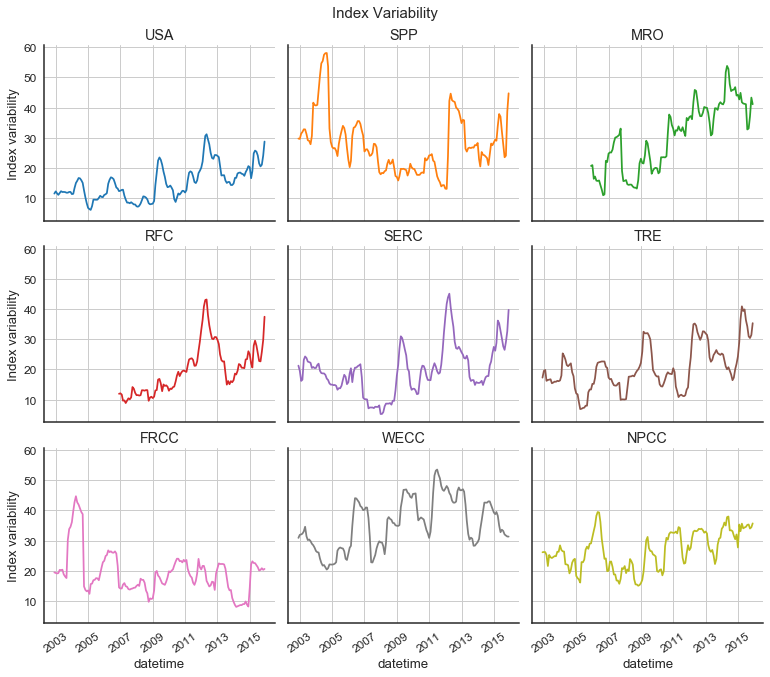

In [63]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(col='region',
                 hue='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order)
region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime',
                  y_axis='Index variability', col_order=order, 
                  suptitle='Index Variability', FG_kwargs=FG_kwargs)

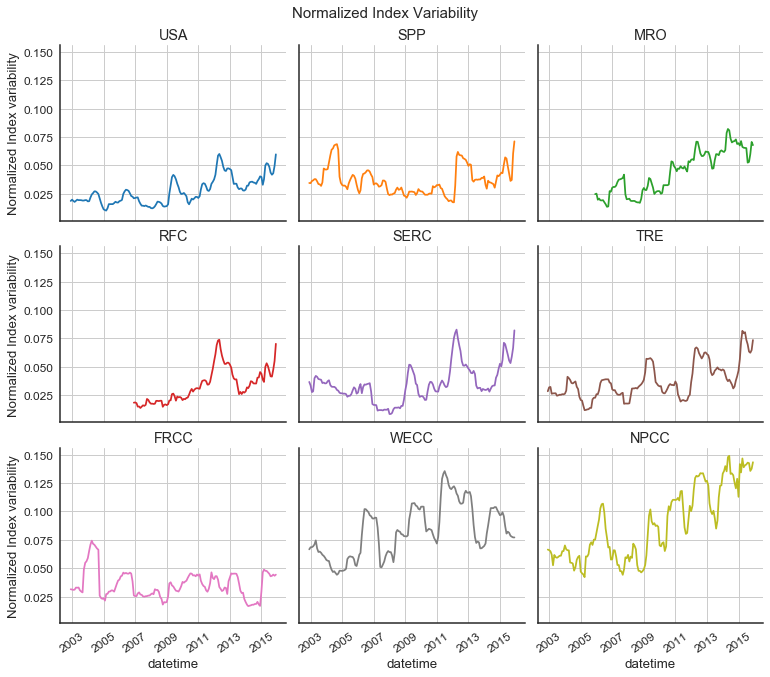

In [64]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(col='region',
                 hue='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order)
region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime',
                  y_axis='Normalized Index variability', col_order=order, 
                  suptitle='Normalized Index Variability', FG_kwargs=FG_kwargs)

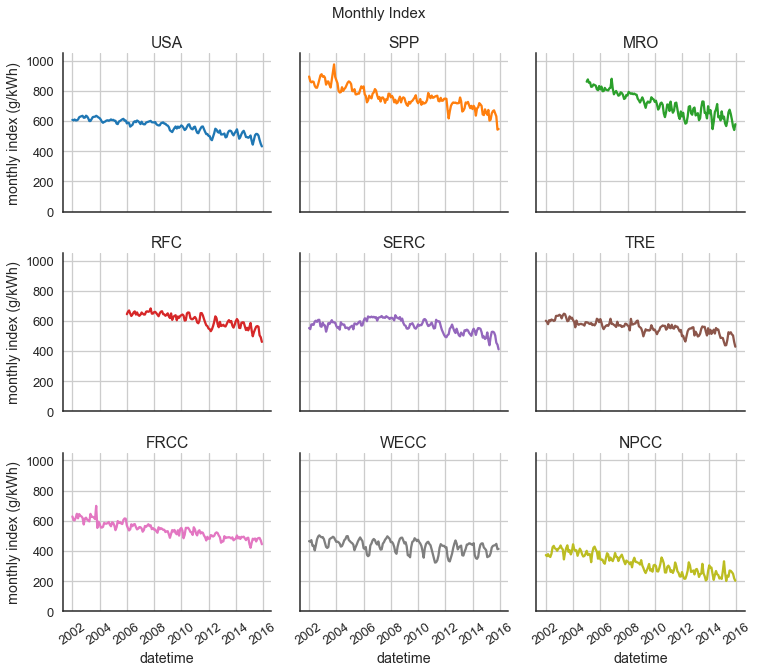

In [18]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(col='region',
                 hue='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 ylim=(0, 1050))

region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime',
                  y_axis='monthly index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index', FG_kwargs=FG_kwargs,
                  context='talk', font_scale=1)

plt.savefig(join('Figures', 'Monthly index.pdf'))

In [22]:
gen_index['month'] = gen_index['datetime'].dt.month
gen_index['year'] = gen_index['datetime'].dt.year

View CO<sub>2</sub> intensity by month, coding the year as a categorical variable.

(0, 1050)

(0, 1050)

(0, 1050)

(0, 1050)

(0, 1050)

(0, 1050)

(0, 1050)

(0, 1050)

(0, 1050)

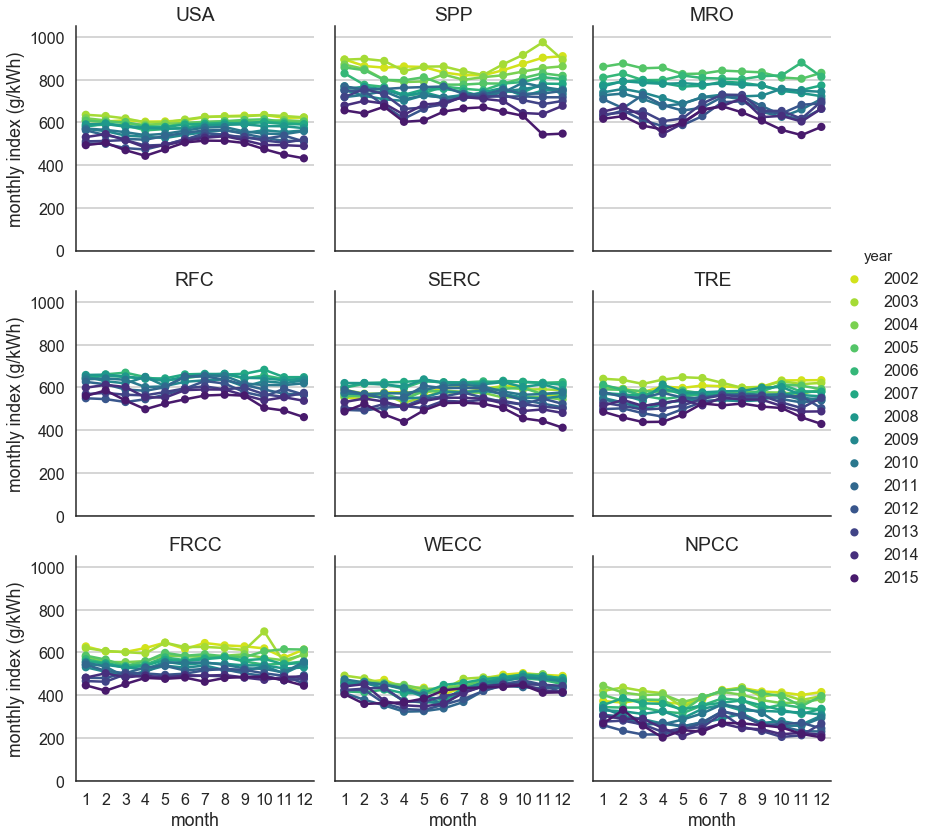

In [38]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
temp = gen_index.copy()

with sns.plotting_context('poster'):

    g = sns.factorplot(x='month', y='monthly index (g/kWh)', hue='year', 
                       data=gen_index, col='region', col_wrap=3, col_order=order, 
                       palette='viridis_r', scale=0.5)
    # plt.suptitle('CO$_2$ Intensity', y=1.02, size=15)

    axes = g.axes.flatten()
    for ax, title in zip(axes, order):
        ax.set_title(title)
        ax.set_ylim(0, 1050)
    
plt.savefig(join('Figures', 'Monthly index (12-months).pdf'))

### Correlation between regions (2006-2015)

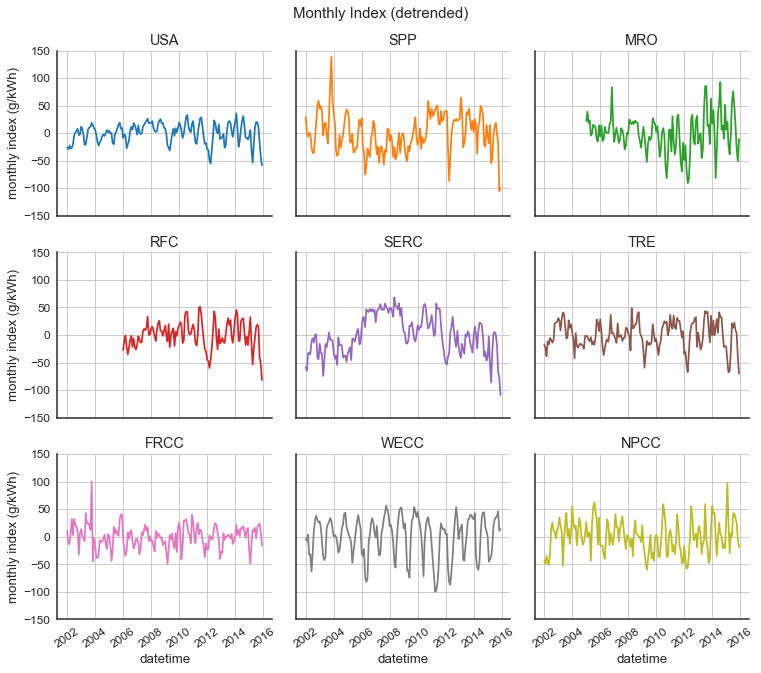

In [19]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
FG_kwargs = dict(hue='region',
                 col='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=order,
                 ylim=(-150, 150))

detrend_df = gen_index.loc[gen_index['region'].isin(order)].copy()
for col in order:
    detrend_df.loc[detrend_df['region'] == col,
                   'monthly index (g/kWh)'] = detrend(detrend_df.loc[detrend_df['region'] == col,
                                                                     'monthly index (g/kWh)'])
    
corr_coef = detrend_df.pivot_table(values='monthly index (g/kWh)',
                                   index='datetime', columns='region').corr()
corr_coef = corr_coef.iloc[1, 0]
region_facet_grid(df=detrend_df, plot_function=plt.plot, x_axis='datetime', #col_order=order,
                  add_legend=False, y_axis='monthly index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index (detrended)', FG_kwargs=FG_kwargs)

In [213]:
def shift_detrend(series, n):
    'Shift a series by n periods to detrend'
    detrended = series - series.shift(n)
    return detrended

In [233]:
a = detrend(gen_index.loc[gen_index['region'] == 'MRO', 'monthly index (g/kWh)'])
b = shift_detrend(gen_index.loc[gen_index['region'] == 'MRO', 'monthly index (g/kWh)'], 1)
c = shift_detrend(gen_index.loc[gen_index['region'] == 'MRO', 'monthly index (g/kWh)'], 12)

In [230]:
import plotly
import plotly.tools as tls
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)

In [234]:
# fig = plt.figure()
time = gen_index.loc[gen_index['region'] == 'MRO', 'datetime']
# plt.plot(time, a, label='Linear detrend')
# plt.plot(time, b, label='First difference')
# plt.legend(loc=0)

data = [go.Scatter(y=a, x=time, name='Linear detrend'),
        go.Scatter(y=b, x=time, name='First differences 1-month'),
        go.Scatter(y=c, x=time, name='First differences 12-months')]
iplot(data)
# plotly_fig = tls.mpl_to_plotly(fig)

# plotly.offline.iplot_mpl(fig, resize=True)

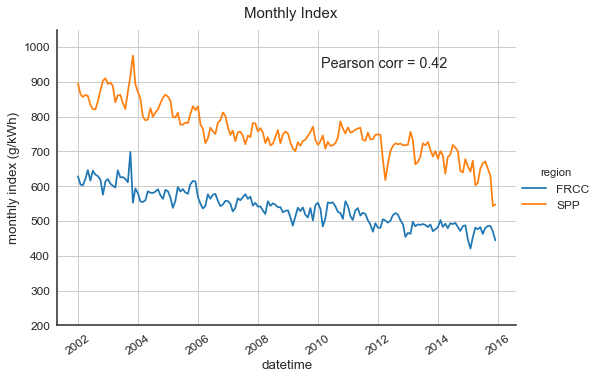

In [159]:
order = ['FRCC', 'SPP']
FG_kwargs = dict(hue='region',
#                  col='region',
#                  col_wrap=3,
                 aspect=1.5,
                 size=5,
                 hue_order=order,
                 ylim=(200, 1050))

# detrend_df = gen_index.loc[gen_index['region'].isin(order)].copy()
# for col in order:
#     detrend_df.loc[detrend_df['region'] == col,
#                    'monthly index (g/kWh)'] = detrend(detrend_df.loc[detrend_df['region'] == col,
#                                                                      'monthly index (g/kWh)'])
    
corr_coef = gen_index.pivot_table(values='monthly index (g/kWh)',
                                   index='datetime', columns='region').corr()
corr_coef = corr_coef.iloc[1, 0]
region_facet_grid(df=gen_index, plot_function=plt.plot, x_axis='datetime', #col_order=order,
                  add_legend=True, y_axis='monthly index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index', FG_kwargs=FG_kwargs)
plt.figtext(.55, .85, 'Pearson corr = {:.2f}'.format(corr_coef))

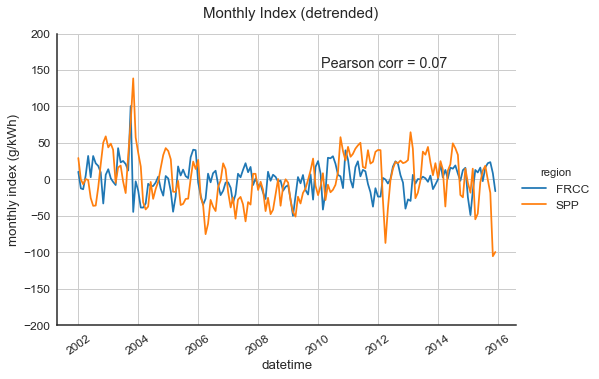

In [160]:
order = ['FRCC', 'SPP']
FG_kwargs = dict(hue='region',
#                  col='region',
#                  col_wrap=3,
                 aspect=1.5,
                 size=5,
                 hue_order=order,
                 ylim=(-200, 200))

detrend_df = gen_index.loc[gen_index['region'].isin(order)].copy()
for col in order:
    detrend_df.loc[detrend_df['region'] == col,
                   'monthly index (g/kWh)'] = detrend(detrend_df.loc[detrend_df['region'] == col,
                                                                     'monthly index (g/kWh)'])
    
corr_coef = detrend_df.pivot_table(values='monthly index (g/kWh)',
                                   index='datetime', columns='region').corr()
corr_coef = corr_coef.iloc[1, 0]
region_facet_grid(df=detrend_df, plot_function=plt.plot, x_axis='datetime', #col_order=order,
                  add_legend=True, y_axis='monthly index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index (detrended)', FG_kwargs=FG_kwargs)
plt.figtext(.55, .85, 'Pearson corr = {:.2f}'.format(corr_coef))

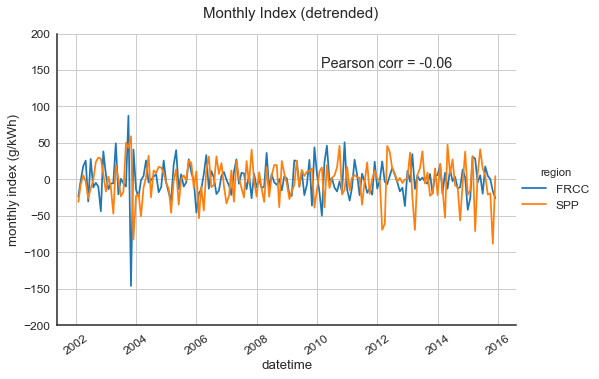

In [214]:
order = ['FRCC', 'SPP']
FG_kwargs = dict(hue='region',
                 aspect=1.5,
                 size=5,
                 hue_order=order,
                 ylim=(-200, 200))

detrend_df = gen_index.loc[gen_index['region'].isin(order)].copy()
for col in order:
    detrend_df.loc[detrend_df['region'] == col,
                   'monthly index (g/kWh)'] = shift_detrend(detrend_df.loc[detrend_df['region'] == col,
                                                                     'monthly index (g/kWh)'], 1)
    
corr_coef = detrend_df.pivot_table(values='monthly index (g/kWh)',
                                   index='datetime', columns='region').corr()
corr_coef = corr_coef.iloc[1, 0]
region_facet_grid(df=detrend_df, plot_function=plt.plot, x_axis='datetime', #col_order=order,
                  add_legend=True, y_axis='monthly index (g/kWh)', col_order=order, 
                  suptitle='Monthly Index (detrended)', FG_kwargs=FG_kwargs)
plt.figtext(.55, .85, 'Pearson corr = {:.2f}'.format(corr_coef))

In [55]:
regions = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
nerc_index = (gen_index.loc[(gen_index['region'].isin(regions)) &
                            (gen_index['Year'] >= 2006)]
              .pivot_table(values='monthly index (g/kWh)',
                           index='datetime', columns='region'))
nerc_index_detrend = pd.DataFrame(index=nerc_index.index)
for col in nerc_index.columns:
    nerc_index_detrend.loc[:, col] = detrend(nerc_index.loc[:, col])

In [56]:
nerc_index_detrend.head()

,FRCC,MRO,NPCC,RFC,SERC,SPP,TRE,USA,WECC
datetime,,,,,,,,,
2006-01-01,2.941309,-1.366440,-6.566193,-27.637832,-38.469825,46.829331,26.573113,-16.700268,-25.886488
2006-02-01,-15.046898,18.888801,-7.628336,-9.782690,-19.224405,-5.195642,3.905515,-10.321605,-30.272832
2006-03-01,-27.799179,-9.809718,-6.578126,-0.850255,-19.868925,-14.191493,-22.764873,-12.727337,-17.273519
2006-04-01,-19.451810,-6.993082,-24.452287,-20.474439,-35.777829,-55.733694,-38.098771,-35.247775,-68.285780
2006-05-01,14.763387,15.762760,-31.344860,-35.228484,-2.934095,-41.785755,-24.960402,-28.510237,-77.522157


Try before 2013 and after 2013 to see if there is a difference.

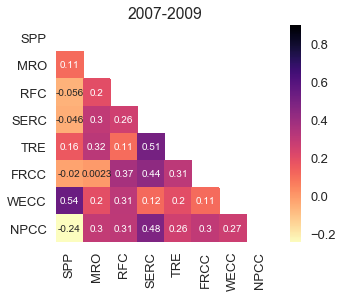

In [58]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
corr = nerc_index_detrend.loc[(nerc_index_detrend.index.year < 2010) &
                              (nerc_index_detrend.index.year >= 2007), order[1:]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, vmax = 0.9, mask=mask, square=True, annot=True,
            annot_kws={'size': 10}, cmap='magma_r')
plt.title('2007-2009')
plt.savefig(join('Figures', '2007-2009 correlation.pdf'), bbox_inches='tight')

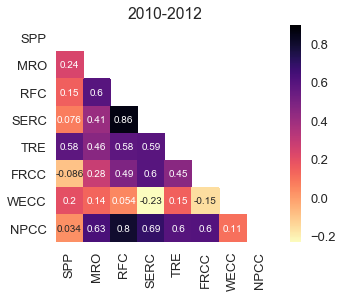

In [59]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
corr = nerc_index_detrend.loc[(nerc_index_detrend.index.year < 2013) &
                              (nerc_index_detrend.index.year >= 2010), order[1:]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, vmax = 0.9, mask=mask, square=True, annot=True,
            annot_kws={'size': 10}, cmap='magma_r')
plt.title('2010-2012')
plt.savefig(join('Figures', '2010-2012 correlation.pdf'), bbox_inches='tight')

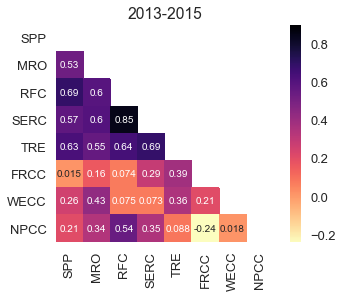

In [60]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
corr = nerc_index_detrend.loc[(nerc_index_detrend.index.year >= 2013), order[1:]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, vmax = 0.9, mask=mask, square=True, annot=True,
            annot_kws={'size': 10}, cmap='magma_r')
plt.title('2013-2015')
plt.savefig(join('Figures', '2013-2015 correlation.pdf'), bbox_inches='tight')

In [87]:
import itertools

In [85]:
def nerc_correlation(df, regions=[], years=[], detrend=True):
    "Pass in non-detrended data. Detrend for just the years of interest"
    
    df_temp = df.loc[(df['region'].isin(regions)) &
                     (df['Year'].isin(years))].copy()
    if detrend:
        for region in regions:
            df_temp.loc[df_temp['region'] == region,
                       'monthly index (g/kWh)'] = detrend(df_temp.loc[df_temp['region'] == region,
                                                                         'monthly index (g/kWh)'])
    corr_df = df_temp.pivot_table(values='monthly index (g/kWh)',
                                  index='datetime', columns='region').corr()
    return corr_df.iloc[1, 0]

In [95]:
years = range(2006, 2016)
df_list = []
for regions in list(itertools.permutations(order[1:], 2)):
    corr_df = pd.DataFrame(columns=['Year', 'Region1', 'Region2', 'Correlation'],
                           index=years)
    corr_df['Year'] = years
    corr_df['Region1'] = regions[0]
    corr_df['Region2'] = regions[1]
    for year in range(2006, 2016): #[years[x:x+2] for x in xrange(0, len(years), 2)]:
        result = nerc_correlation(gen_index, regions=regions, years=[year], detrend=False)
        corr_df.loc[year, 'Correlation'] = result
    df_list.append(corr_df)

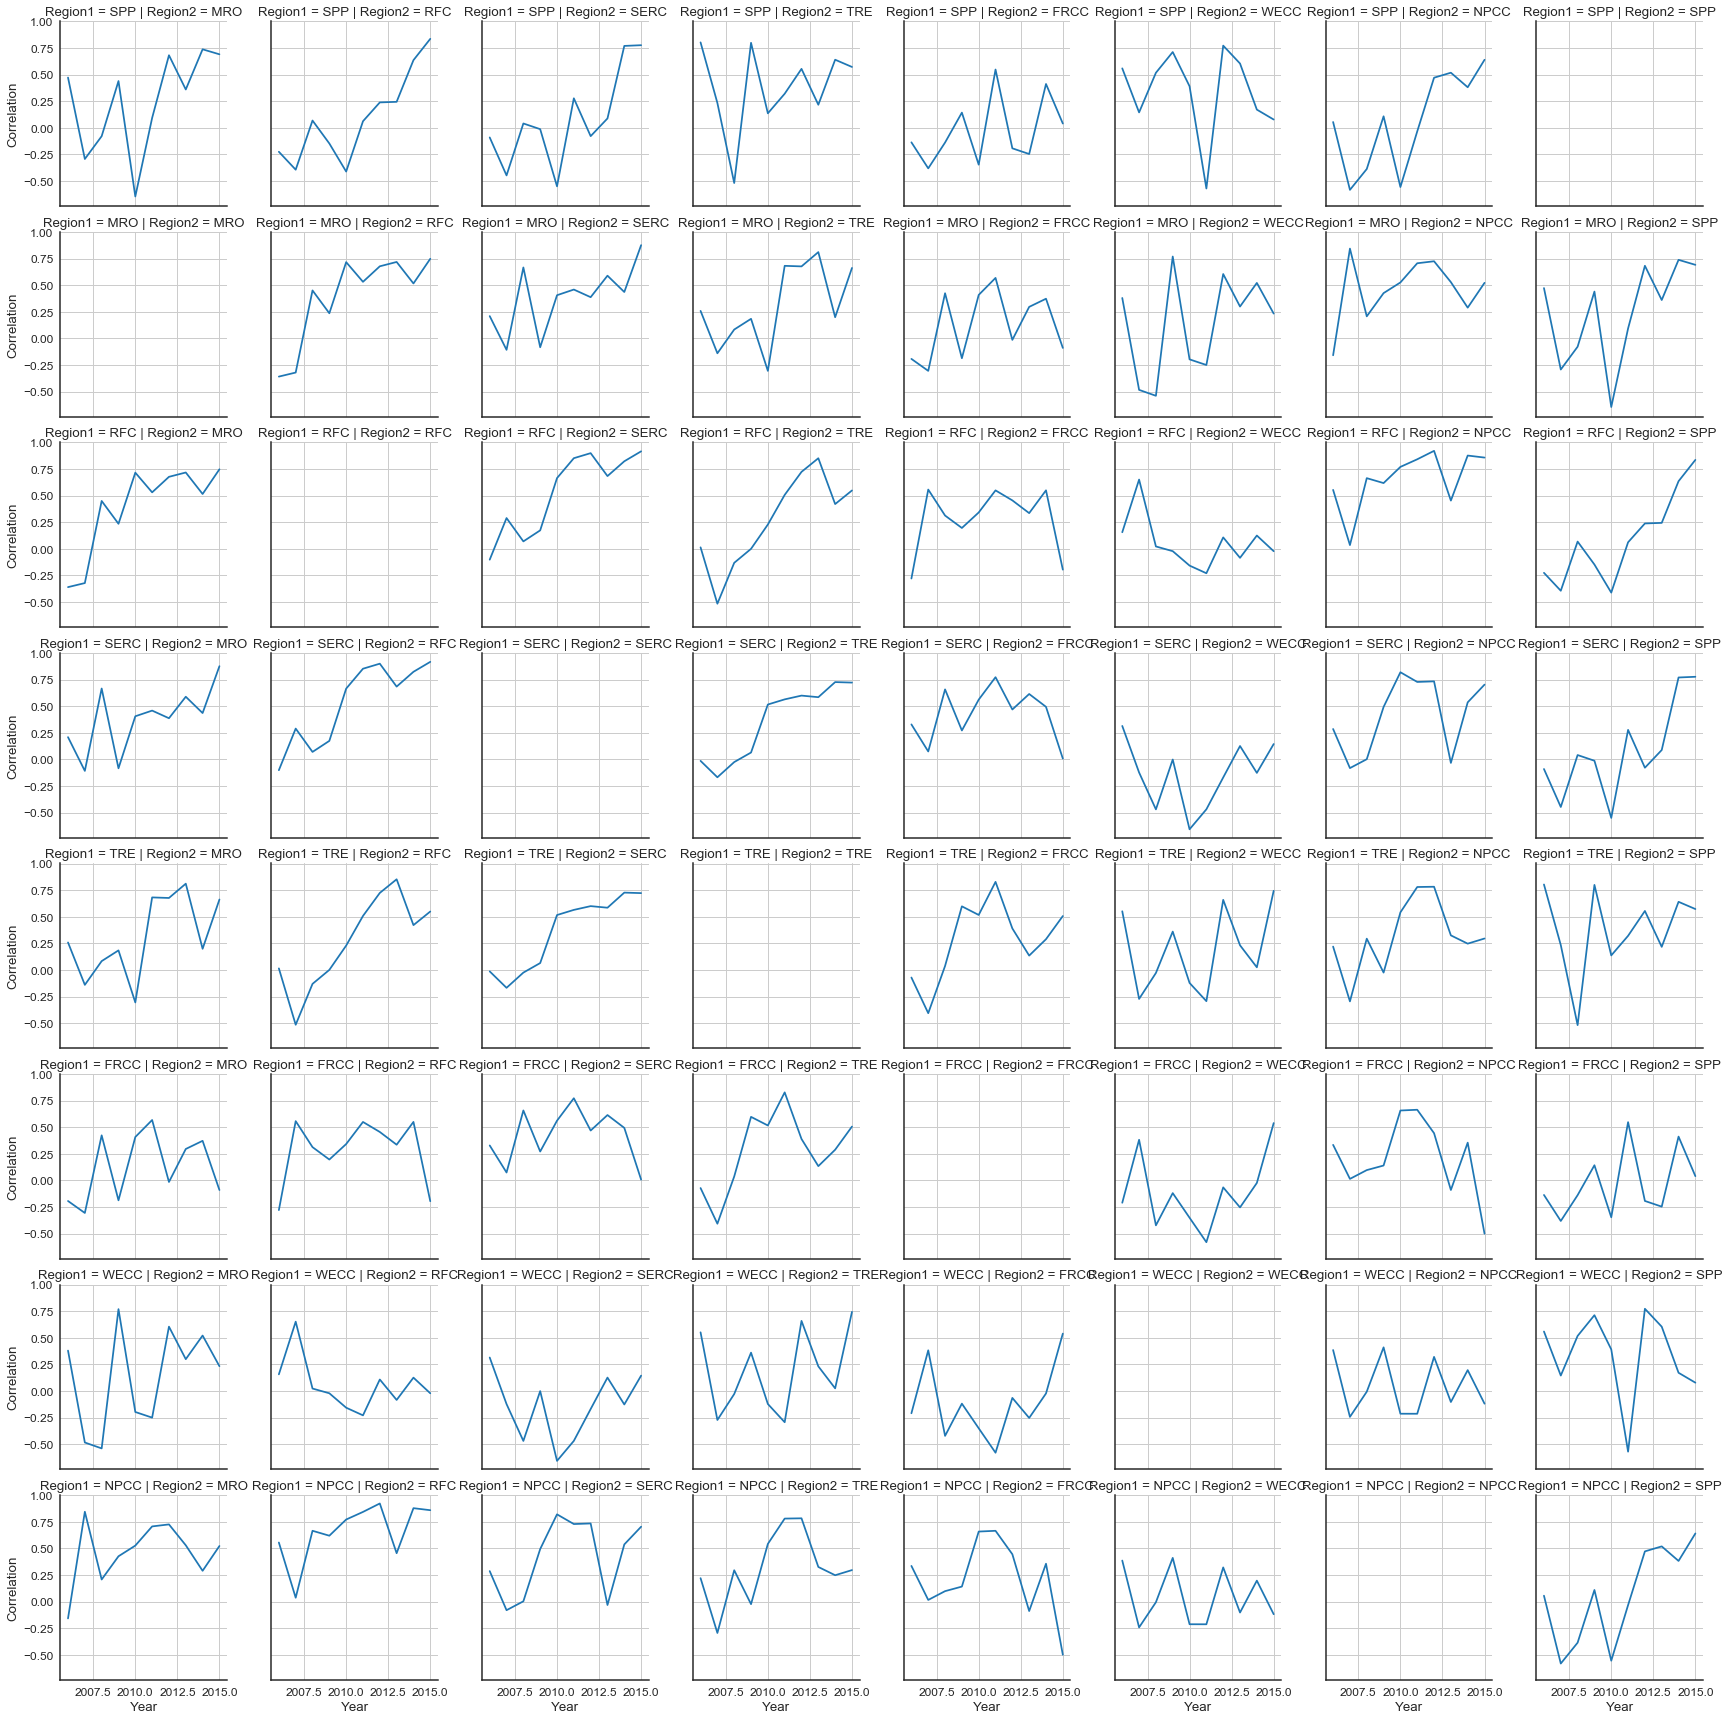

In [96]:
g = sns.FacetGrid(pd.concat(df_list), row='Region1', col='Region2')
g.map(plt.plot, 'Year', 'Correlation')

### Percent of fuel in each region

In [29]:
all_fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Other', 'Other Renewables',
                 'Wind', 'Solar', 'Hydro']
value_cols = ['percent {}'.format(fuel) for fuel in all_fuels]

percent_gen_df = pd.melt(gen_index, id_vars=['region', 'datetime'], 
        value_vars=value_cols, value_name='percent generation',
                        var_name='fuel')
percent_gen_df['fuel'] = percent_gen_df['fuel'].map(lambda x: x.split()[-1])
percent_gen_df['fuel'].replace('Renewables', 'Other Renewables', inplace=True)
percent_gen_df['fuel'].replace('Gas', 'Natural Gas', inplace=True)

In [30]:
gen_index.head()

,region,datetime,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,...,percent Other,change in Other,percent Solar,change in Solar,percent Wind,change in Wind,percent Hydro,change in Hydro,change in variability,change in norm variability
0,ASCC,2002-01-01,51623.345,118944.230,278301.715,0.0,105692.359,1091.837,0.0,0.0,...,0.190213,0.284681,0.0,NaN,0.0,-1.0,0.214062,0.130866,NaN,NaN
1,ASCC,2002-02-01,44698.280,111685.818,226043.409,0.0,93737.860,920.883,0.0,0.0,...,0.196480,0.327009,0.0,NaN,0.0,-1.0,0.234100,0.236724,NaN,NaN
2,ASCC,2002-03-01,48946.119,114826.098,242509.602,0.0,95438.279,1001.716,0.0,0.0,...,0.189843,0.282185,0.0,NaN,0.0,-1.0,0.228409,0.206659,NaN,NaN
3,ASCC,2002-04-01,43484.123,111308.793,234060.059,0.0,67238.126,951.725,0.0,0.0,...,0.147116,-0.006393,0.0,NaN,0.0,-1.0,0.243541,0.286602,NaN,NaN
4,ASCC,2002-05-01,48711.393,108503.867,220310.309,0.0,68730.377,1002.904,0.0,0.0,...,0.153670,0.037876,0.0,NaN,0.0,-1.0,0.242597,0.281616,NaN,NaN


In [31]:
percent_gen_df.head()

,region,datetime,fuel,percent generation
0,ASCC,2002-01-01,Coal,0.092906
1,ASCC,2002-02-01,Coal,0.093690
2,ASCC,2002-03-01,Coal,0.097362
3,ASCC,2002-04-01,Coal,0.095142
4,ASCC,2002-05-01,Coal,0.108911


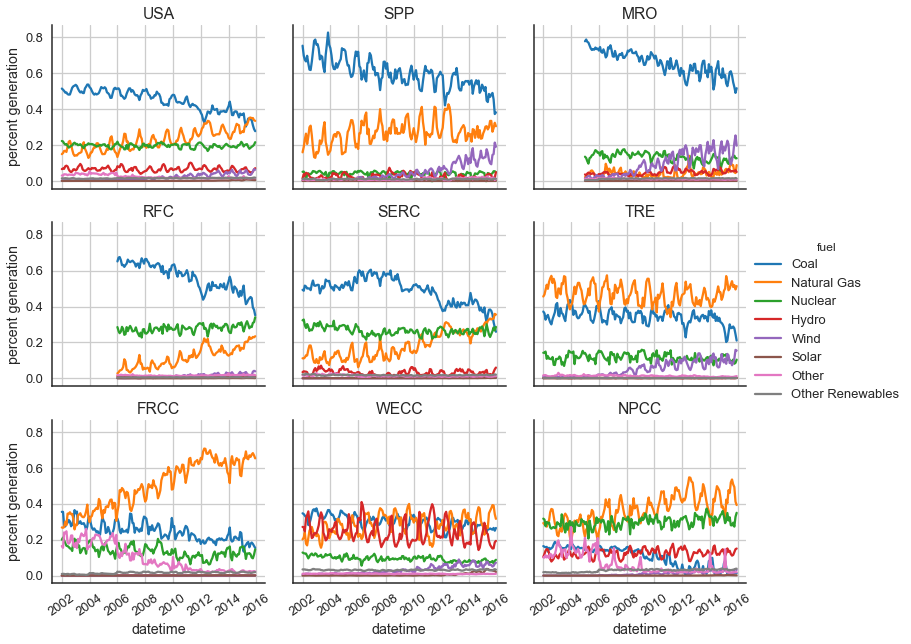

In [32]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuel_order = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar',
              'Other', 'Other Renewables']
FG_kwargs = dict(hue='fuel',
                 col='region',
                 col_wrap=3,
                 aspect=1.2,
                 hue_order=fuel_order)

region_facet_grid(df=percent_gen_df, plot_function=plt.plot, x_axis='datetime',
                  add_legend=True, y_axis='percent generation', col_order=order, 
                  suptitle='', FG_kwargs=FG_kwargs,
                  context='talk', font_scale=1)

plt.savefig(join('Figures', 'Generation by fuel.pdf'))

In [46]:
percent_gen_df['month'] = percent_gen_df['datetime'].dt.month
percent_gen_df['year'] = percent_gen_df['datetime'].dt.year

In [47]:
percent_gen_df.head()

,region,datetime,fuel,percent generation,month,year
0,ASCC,2002-01-01,Coal,0.092906,1,2002
1,ASCC,2002-02-01,Coal,0.093690,2,2002
2,ASCC,2002-03-01,Coal,0.097362,3,2002
3,ASCC,2002-04-01,Coal,0.095142,4,2002
4,ASCC,2002-05-01,Coal,0.108911,5,2002


#### Looking at seasonal variation in generation across different regions and timeframes.

All regions, from 2013 through 2015

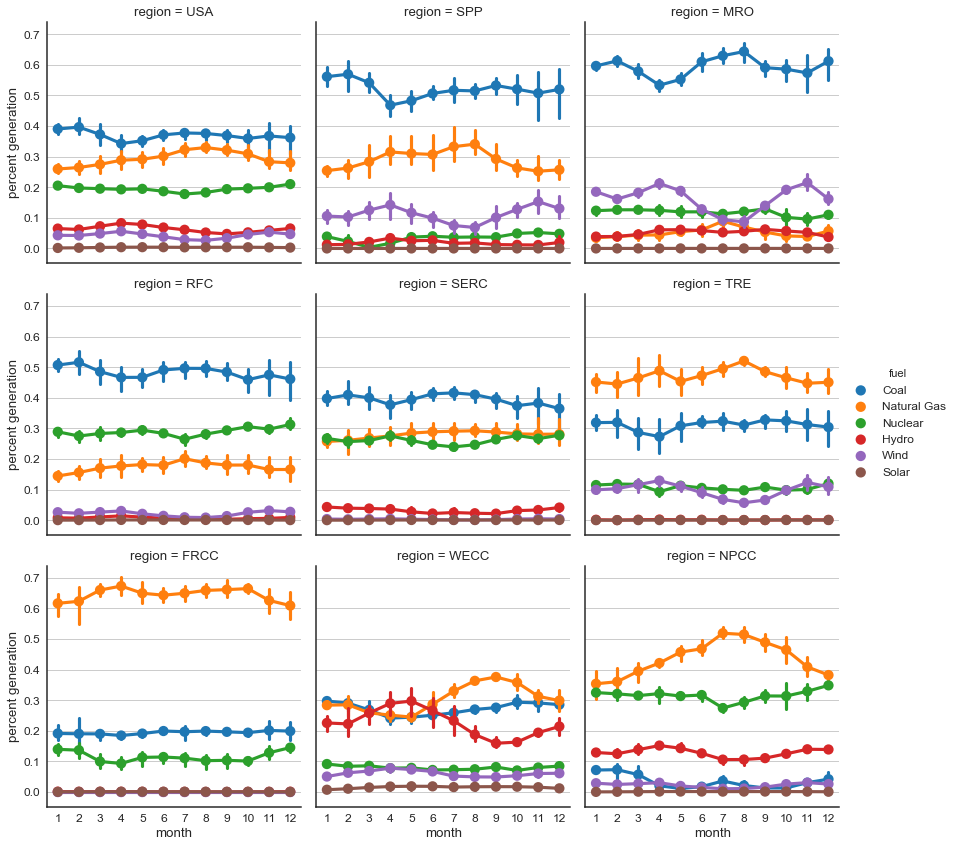

In [35]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
temp_df = percent_gen_df.loc[(percent_gen_df.fuel.isin(fuels)) & 
                             (percent_gen_df.datetime.dt.year >= 2012)]
sns.factorplot(x='month', y='percent generation', hue='fuel', data=temp_df,
              col='region', col_wrap=3, col_order=order, hue_order=fuels)

All regions, before 2013

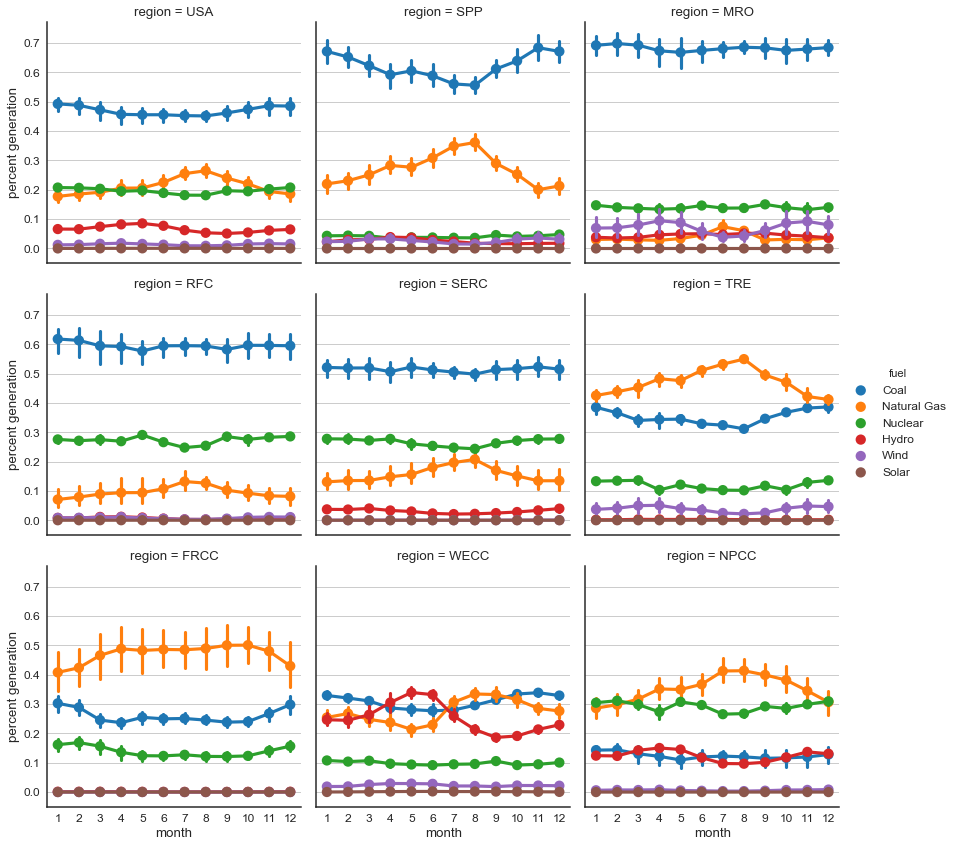

In [36]:
order = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
temp_df = percent_gen_df.loc[(percent_gen_df.fuel.isin(fuels)) & 
                             (percent_gen_df.datetime.dt.year <= 2012)]
sns.factorplot(x='month', y='percent generation', hue='fuel', data=temp_df,
              col='region', col_wrap=3, col_order=order, hue_order=fuels)

Only coal, NG, and wind in SPP. All years in each facet

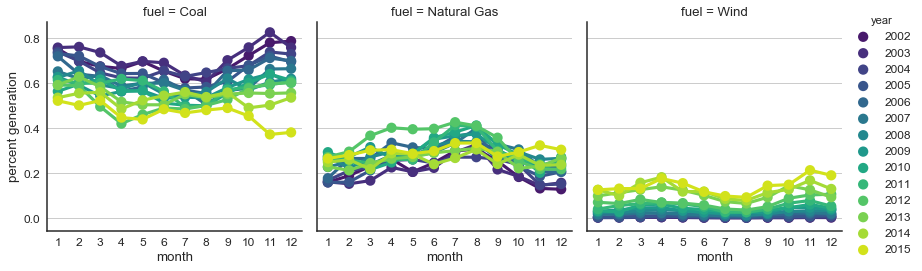

In [49]:
order = ['SPP']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
temp_df = percent_gen_df.loc[(percent_gen_df.fuel.isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (percent_gen_df.region.isin(order))]
sns.factorplot(x='month', y='percent generation', hue='year', data=temp_df,
               col='fuel', palette='viridis')
# sns.factorplot(x='month', y='percent generation', hue='fuel', data=temp_df,
#               col='year', col_wrap=3, hue_order=fuels)

In [109]:
order = ['SPP', 'TRE', 'MRO']
fuels = ['Coal', 'Natural Gas', 'Nuclear', 'Hydro', 'Wind', 'Solar']
temp_df = percent_gen_df.loc[(percent_gen_df.fuel.isin(['Wind', 'Coal', 'Natural Gas'])) & 
                             (percent_gen_df.region.isin(order)) &
                             (percent_gen_df.year >=2007)].copy()
def early_late(x):
    if x < 2010:
        return 'Early'
    elif x < 2013:
        return 'Mid'
    elif x >= 2013:
        return 'Late'
    else:
        return ValueError

temp_df.loc[:, 'timeframe'] = temp_df.loc[:, 'year'].map(early_late)
merge_cols = ['region', 'month', 'year']
temp_df = pd.merge(temp_df, gen_index[merge_cols + ['Total gen']],
                   on=merge_cols)
temp_df['generation'] = (temp_df.loc[:, 'percent generation']
                         * temp_df.loc[:, 'Total gen'] / 1e6)

In [110]:
# a is the list of colors to get wind purple
a = sns.color_palette('tab10')[0:2]
a.append(sns.color_palette('tab10')[4])

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


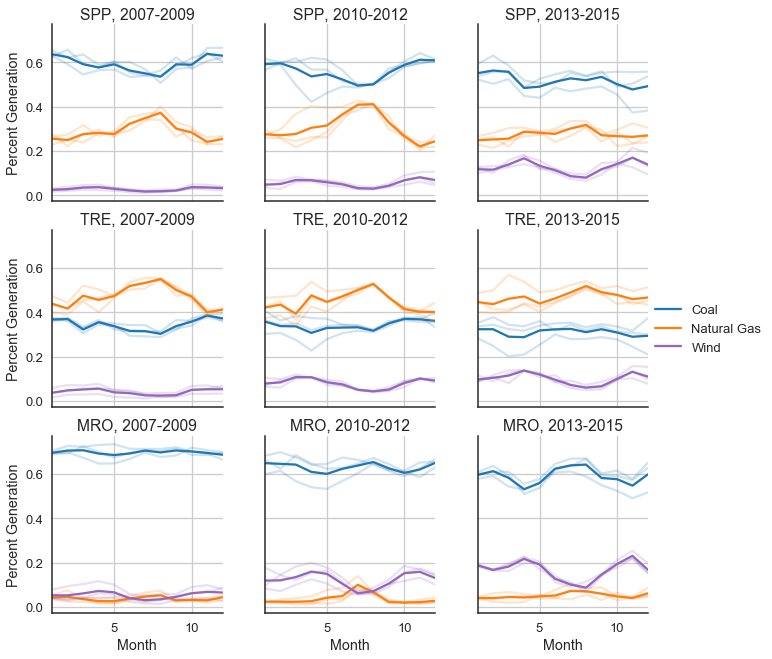

In [111]:
with sns.plotting_context(font_scale=1.2):
    g = sns.FacetGrid(temp_df, col='timeframe', row='region',
                      col_order=['Early', 'Mid', 'Late'], row_order=order)
    g.map_dataframe(sns.tsplot, time='month', unit='year', value='percent generation', 
                    condition='fuel', err_style='unit_traces', color=a).add_legend()
    g.set_axis_labels('Month', 'Percent Generation')
    titles = ['{}, {}'.format(a, b) for (a, b) in 
              list(itertools.product(order, ['2007-2009', '2010-2012', '2013-2015']))]
    axes = g.axes.flatten()
    for ax, title in zip(axes, titles):
        ax.set_title(title)
# plt.savefig(join('Figures', 'Adding wind.pdf'), bbox_inches='tight')

In [100]:
temp_df.groupby(['region',  'fuel', 'timeframe']).mean()

percent generation  month    year
region fuel        timeframe                                   
MRO    Coal        Early                0.630208    6.5  2011.0
                   Late                 0.590813    6.5  2014.0
       Natural Gas Early                0.037343    6.5  2011.0
                   Late                 0.051716    6.5  2014.0
       Wind        Early                0.122331    6.5  2011.0
                   Late                 0.166540    6.5  2014.0
SPP    Coal        Early                0.559864    6.5  2011.0
                   Late                 0.517152    6.5  2014.0
       Natural Gas Early                0.306936    6.5  2011.0
                   Late                 0.274068    6.5  2014.0
       Wind        Early                0.055447    6.5  2011.0
                   Late                 0.126280    6.5  2014.0
TRE    Coal        Early                0.342231    6.5  2011.0
                   Late                 0.310446    6.5  2014.0
       Natural Gas Early                0.447095    6.5  2011.0
                   Late                 0.469053    6.5  2014.0
       Wind        Early                0.080329    6.5  2011.0
                   Late                 0.101316    6.5  2014.0

/Users/Home/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


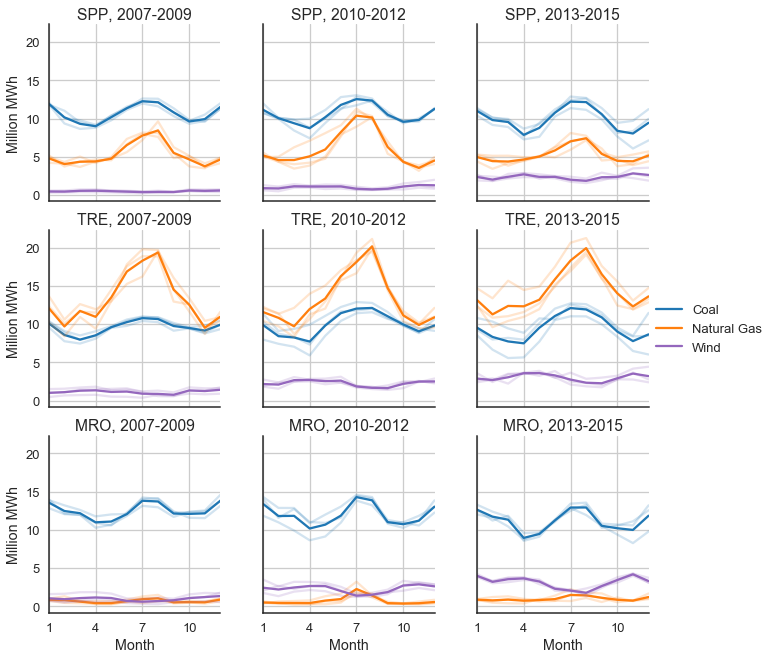

In [113]:
with sns.plotting_context(font_scale=1.2):
    g = sns.FacetGrid(temp_df, col='timeframe', row='region',
                      col_order=['Early', 'Mid', 'Late'], row_order=order)
    g.map_dataframe(sns.tsplot, time='month', unit='year', value='generation', 
                    condition='fuel', err_style='unit_traces', color=a).add_legend()
    g.set_axis_labels('Month', 'Million MWh')
    titles = ['{}, {}'.format(a, b) for (a, b) in 
              list(itertools.product(order, ['2007-2009', '2010-2012', '2013-2015']))]
    axes = g.axes.flatten()
    for ax, title in zip(axes, titles):
        ax.set_title(title)
        ax.set_xticks([1, 4, 7, 10])
# plt.savefig(join('Figures', 'Adding wind.pdf'), bbox_inches='tight')

Look at the growth in average monthly wind generation across the two timeframes, and the change in natural gas/coal generation.



In [103]:
temp_df.groupby(['region',  'fuel', 'timeframe']).mean()

percent generation  month    year     Total gen  \
region fuel        timeframe                                                    
MRO    Coal        Early                0.630208    6.5  2011.0  1.896983e+07   
                   Late                 0.590813    6.5  2014.0  1.879558e+07   
       Natural Gas Early                0.037343    6.5  2011.0  1.896983e+07   
                   Late                 0.051716    6.5  2014.0  1.879558e+07   
       Wind        Early                0.122331    6.5  2011.0  1.896983e+07   
                   Late                 0.166540    6.5  2014.0  1.879558e+07   
SPP    Coal        Early                0.559864    6.5  2011.0  1.916001e+07   
                   Late                 0.517152    6.5  2014.0  1.908230e+07   
       Natural Gas Early                0.306936    6.5  2011.0  1.916001e+07   
                   Late                 0.274068    6.5  2014.0  1.908230e+07   
       Wind        Early                0.055447    6.5  2011.0  1.916001e+07   
                   Late                 0.126280    6.5  2014.0  1.908230e+07   
TRE    Coal        Early                0.342231    6.5  2011.0  2.922892e+07   
                   Late                 0.310446    6.5  2014.0  3.056596e+07   
       Natural Gas Early                0.447095    6.5  2011.0  2.922892e+07   
                   Late                 0.469053    6.5  2014.0  3.056596e+07   
       Wind        Early                0.080329    6.5  2011.0  2.922892e+07   
                   Late                 0.101316    6.5  2014.0  3.056596e+07   

                              generation  
region fuel        timeframe              
MRO    Coal        Early       11.984091  
                   Late        11.138114  
       Natural Gas Early        0.736706  
                   Late         0.978960  
       Wind        Early        2.272135  
                   Late         3.102439  
SPP    Coal        Early       10.613247  
                   Late         9.882392  
       Natural Gas Early        6.062922  
                   Late         5.262823  
       Wind        Early        1.024581  
                   Late         2.350254  
TRE    Coal        Early        9.969315  
                   Late         9.510300  
       Natural Gas Early       13.227784  
                   Late        14.417579  
       Wind        Early        2.264802  
                   Late         3.012674

(-0.1, 1.1)

(-0.1, 1.1)

(-0.1, 1.1)

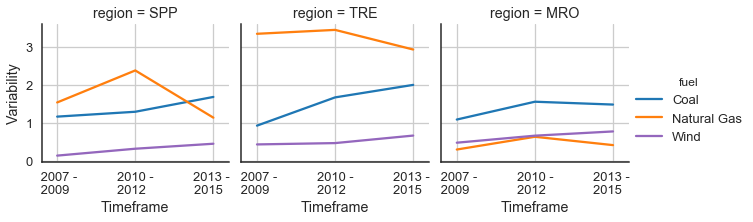

In [126]:
map_timeframe = {'Early': 0,
                 'Mid': 0.5,
                 'Late': 1}

data = (temp_df.groupby(['region', 'fuel', 'timeframe'])
                   .std()
                   .reset_index())
data['frame'] = data['timeframe'].map(map_timeframe)
data.sort_values(['region', 'fuel', 'frame'], inplace=True)

g = sns.FacetGrid(data, hue='fuel', col='region',
                  col_order=['SPP', 'TRE', 'MRO'], palette=a)
g.map(plt.plot, 'frame', 'generation').add_legend()
g.set_axis_labels('Timeframe', 'Variability')
axes = g.axes.flatten()
for ax in axes:
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels([' 2007 -\n 2009  ', '2010 -\n2012  ',
                        '2013 - \n2015   '])
    ax.set_xlim(-.1, 1.1)

## Annual index values

In [175]:
annual_gen_index.head()

,region,Year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,index (g/kWh)
0,FRCC,2001,3.635751e+08,2.204357e+07,5.138395e+07,187650128.0,8.122448e+06,0.000000e+00,0.0,0.0,609.802294
1,FRCC,2002,4.412558e+08,2.651508e+07,1.147544e+08,252761123.0,1.340431e+07,1.920941e+07,0.0,4068.0,580.658585
2,FRCC,2003,4.414591e+08,4.235141e+07,8.931378e+07,246944988.0,1.778760e+07,1.318030e+07,0.0,3933.0,579.308184
3,FRCC,2004,4.517296e+08,3.521664e+07,1.098346e+08,256364920.0,2.040076e+07,1.683418e+07,0.0,3813.0,562.939848
4,FRCC,2005,4.805494e+08,3.418739e+07,1.181784e+08,251513134.0,1.651148e+07,1.646854e+07,0.0,3339.0,574.508693


In [181]:
annual_gen_index.loc[annual_gen_index['region'] == 'SERC']

,region,Year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,index (g/kWh)
55,SERC,2001,7.151246e+06,1.829287e+07,2.943617e+06,34726301.0,7.586375e+06,1.773350e+05,0.00,12133.000,218.322689
56,SERC,2002,4.198732e+07,2.942033e+07,8.175643e+07,73561762.0,2.919109e+07,4.808592e+06,0.00,91998.000,395.725502
57,SERC,2003,4.278476e+07,2.996434e+07,7.289092e+07,75455695.0,3.876786e+07,3.908553e+06,0.00,52030.001,405.117318
58,SERC,2004,4.191305e+07,2.989485e+07,7.522369e+07,77153595.0,4.009624e+07,4.774855e+06,0.00,109016.000,394.775591
59,SERC,2005,4.078794e+07,3.309260e+07,8.124198e+07,77007763.0,4.355358e+07,5.517152e+06,0.00,114475.999,389.669146
60,SERC,2006,4.059439e+07,3.539775e+07,9.493770e+07,79147382.0,1.509632e+07,8.562950e+06,0.00,666058.999,347.256614
61,SERC,2007,4.147160e+07,3.045338e+07,9.940021e+07,79426397.0,1.735074e+07,8.980801e+06,0.00,943058.002,352.396734
62,SERC,2008,3.797199e+07,3.452639e+07,9.509392e+07,78756123.0,1.078319e+07,8.844715e+06,80.19,1406547.310,324.155219
63,SERC,2009,2.719829e+07,3.569982e+07,9.280932e+07,79715298.0,8.245965e+06,8.467415e+06,42.57,2644983.520,288.293521
64,SERC,2010,2.766289e+07,3.264042e+07,1.075385e+08,80230180.0,6.840508e+06,8.565847e+06,824.26,3155407.470,299.926632


In [177]:
regions = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
for region in regions:
    temp = annual_gen_index.loc[annual_gen_index['region'] == region]
    start_year = temp.loc[:, 'Year'].values[0]
    start = temp.loc[:, 'index (g/kWh)'].values[0]
    end = temp.loc[:, 'index (g/kWh)'].values[-1]
    
    change = (end - start) / start * 100
    
    print '{} declined {:.1f}%, from {:.1f} in {} to {:.1f}'.format(region, change,
                                                            start, start_year,
                                                            end)

USA declined -9.4%, from 538.2 in 2002 to 487.7
SPP declined -53.5%, from 1003.9 in 2001 to 467.2
MRO declined -16.5%, from 783.4 in 2002 to 654.3
RFC declined -27.5%, from 838.3 in 2005 to 608.0
SERC declined 14.8%, from 218.3 in 2001 to 250.7
TRE declined -17.5%, from 649.3 in 2006 to 535.9
FRCC declined -20.0%, from 609.8 in 2001 to 487.5
WECC declined -34.4%, from 962.7 in 2001 to 631.6
NPCC declined -24.6%, from 642.2 in 2001 to 484.4


In [186]:
gen_index.loc[gen_index['region'] == 'USA', ['datetime', 'monthly index (g/kWh)']]

,datetime,monthly index (g/kWh)
1500,2002-01-01,607.894450
1501,2002-02-01,604.119188
1502,2002-03-01,610.360180
1503,2002-04-01,603.583763
1504,2002-05-01,604.596839
1505,2002-06-01,609.809488
1506,2002-07-01,624.623198
1507,2002-08-01,629.097980
1508,2002-09-01,631.823110
1509,2002-10-01,634.634598


In [187]:
df_list = []
for f in ai_fns:
    region = f.split()[-1][:-4]
    df = pd.read_csv(f)
    df['region'] = region
    df_list.append(df)
full_ai = pd.concat(df_list)
full_ai.reset_index(inplace=True, drop=True)
# full_ai.rename(columns={'index (g/kWh)': 'monthly index (g/kWh)'}, inplace=True)

In [190]:
df_list = []
for f in ag_fns:
    region = f.split()[-1][:-4]
    df = pd.read_csv(f)
    df['region'] = region
    df_list.append(df)
full_ag = pd.concat(df_list)
full_ag.reset_index(inplace=True, drop=True)
# full_ag['datetime'] = pd.to_datetime(full_ag['datetime'])

annual_gen = pd.pivot_table(full_ag, index=['region', 'year'], 
                             values='generation (MWh)', columns='fuel category')
annual_gen.reset_index(inplace=True, drop=False)
annual_gen.replace(np.nan, 0, inplace=True)

In [198]:
annual_gen_index = pd.merge(annual_gen, full_ai[['year', 'region', 'index (g/kWh)']], 
                     on=['year', 'region'])
annual_gen_index.head()

,region,year,Coal,Hydro,Natural Gas,Nuclear,Other,Other Renewables,Solar,Wind,index (g/kWh)
0,ASCC,2002,5.752878e+05,1439351.001,2.797913e+06,0.0,931895.38600,12155.00000,0.0,0.000,538.205197
1,ASCC,2003,4.567480e+05,1582536.373,3.205922e+06,0.0,843198.12100,5776.58000,0.0,0.000,536.534989
2,ASCC,2004,6.489797e+05,1498020.009,3.623433e+06,0.0,747068.07261,9216.50560,0.0,0.000,535.042630
3,ASCC,2005,1.920282e+06,1463942.006,3.723626e+06,0.0,847097.54313,5255.56792,0.0,589.000,633.494336
4,ASCC,2006,6.174190e+05,1223607.006,4.057730e+06,0.0,767987.90118,6664.50779,0.0,788.001,560.168854


In [202]:
regions = ['USA', 'SPP', 'MRO', 'RFC', 'SERC', 'TRE', 'FRCC', 'WECC', 'NPCC']
for region in regions:
    temp = annual_gen_index.loc[annual_gen_index['region'] == region]
    start_year = temp.loc[:, 'year'].values[0]
    start = temp.loc[:, 'index (g/kWh)'].values[0]
    if region in ['FRCC', 'NPCC', 'USA']:
        start = temp.loc[:, 'index (g/kWh)'].values[1]
        start_year = temp.loc[:, 'year'].values[1]
    
    end = temp.loc[:, 'index (g/kWh)'].values[-1]
    
    per_change = (start - end) / start * 100
    change = start - end
    rate = change / (2015 - start_year)
    
    print '''{} declined {:.1f} ({:.1f}%), from {:.1f} in {} to {:.1f},
    a rate of {:.1f}'''.format(region, change, per_change, start, start_year,
                           end, rate)

USA declined 133.8 (21.7%), from 617.6 in 2002 to 483.8,
    a rate of 10.3
SPP declined 331.1 (34.4%), from 962.7 in 2001 to 631.6,
    a rate of 23.6
MRO declined 230.3 (27.5%), from 838.3 in 2005 to 608.0,
    a rate of 23.0
RFC declined 113.3 (17.5%), from 649.3 in 2006 to 535.9,
    a rate of 12.6
SERC declined 122.3 (20.0%), from 609.8 in 2001 to 487.5,
    a rate of 8.7
TRE declined 157.8 (24.6%), from 642.2 in 2001 to 484.4,
    a rate of 11.3
FRCC declined 153.7 (24.7%), from 620.9 in 2002 to 467.2,
    a rate of 11.8
WECC declined 54.5 (11.8%), from 463.1 in 2002 to 408.6,
    a rate of 4.2
NPCC declined 145.0 (36.6%), from 395.7 in 2002 to 250.7,
    a rate of 11.2
